In [1]:
import pandas as pd
import numpy as np
import tensorflow as tf
from sklearn.model_selection import train_test_split
from sklearn.utils import shuffle
import matplotlib.pyplot as plt
import hashlib
import math, os
from tqdm import tqdm

C:\Users\taker\Anaconda3\lib\site-packages\h5py\__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


In [2]:
pd.set_option('display.max_columns', 40)

In [3]:
# トレーニング用の入力データの選択
X_columns = ['locality', 'age', 'rank', 'leg', 'racing piont', \
             'S', 'B', 'Nige', 'Maki', 'Sashi', 'Ma', \
             '1st', '2nd', '3rd', 'Chakugai', 'win', '2ren', '3ren']


In [4]:
# Webスクレイピングで取得した戦績データをファイルから読み取り、データフレームに変換＋データ前処理
def get_df_train(places):
    
    init_flag = True
    for place in places:
        print('loading data for ' + place)
        filename = "data/" + place + "_train_data.csv"
        df_train = pd.read_csv(filename, encoding="SHIFT_JIS", header=0, nrows=None)

        targets = []
        name_ids = []
        localities = []

        for index, row in df_train.iterrows():

            # 1位を予想するため One-Hot表現にする
            result = row['result']
            if result == 1:
                target = 1
            else:
                target = 0
            targets.append(target)    

            # 名前をハッシュを使ってID化
            name = row['name']
            name_hash = hashlib.md5(name.encode()).hexdigest()
            name_id = name_hash[-8:]
            name_ids.append(name_id)

            # 　ランクの例外処理
            if row['rank'] == 'SS':
                df_train.loc[index, 'rank'] = '0'
            elif row['rank'] == 'L1':
                df_train.loc[index, 'rank'] = '6'

            # 出身地を地区毎にグループ化
            prefecture = row['prefecture']
            if prefecture in {'1', '2', '3', '5'}:
                locality = '1' #北東北
            elif prefecture in {'4', '6', '7'}:
                locality = '2' #南東北
            elif prefecture in {'8', '9'}:
                locality = '3' #茨栃
            elif prefecture in {'11', '13'}:
                locality = '4' #埼京
            elif prefecture in {'10', '15', '19', '20'}:
                locality = '5' #上信越
            elif prefecture in {'12', '14', '22'}:
                locality = '6' #南関東
            elif prefecture in {'16', '17', '21', '23', '24'}:
                locality = '7' #中部
            elif prefecture in {'18', '25', '26', '27', '28', '29', '30'}:
                locality = '8' #近畿
            elif prefecture in {'31', '32', '33', '34', '35'}:
                locality = '9' #中国
            elif prefecture in {'36', '37', '38', '39'}:
                locality = '10' #四国
            elif prefecture in {'40', '41', '42', '43', '44', '45', '46', '47'}:
                locality = '11' #九州
            else:
                locality = '12' #外国

            localities.append(locality)

        # 前処理したデータのデータフレームへの置き換え
        df_train['target'] = targets
        df_train['name_id'] = name_ids
        df_train['locality'] = localities

        # カラムの順番入れ替え（見やすさのため）
        columns = list(df_train.columns)
        columns.remove('name_id')
        columns.insert(columns.index("name") + 1, "name_id")
        columns.remove('locality')
        columns.insert(columns.index("prefecture") + 1, "locality")

        df_train = df_train.loc[:,columns]
        
        if init_flag:
            df_train_concat = df_train
            init_flag = False
        else:
            df_train_concat = pd.concat([df_train_concat, df_train])
    
    return df_train_concat

In [5]:
def get_train_test_data(df_train):
    X = []
    target = []
        
    # 各レース毎に
    grouped = df_train.groupby(['date', 'place', 'race_num'])
    for race_name, group in tqdm(grouped):
        #print(race_name)
        racer_count = group.shape[0]
        # もし、９輪ではないレースは、トレーニングの対象から外す（モデルを固めるため）
        if racer_count != 9:
            continue
        X.append(group[X_columns].values)
        target.append(group['target'].values)

    X = np.array(X)
    X = X.reshape(X.shape[0], X.shape[1] * X.shape[2])
    d_ = np.array(target)

    X_train, X_test, d_train, d_test = train_test_split(X, d_, test_size = 0.2)

    return X_train, X_test, d_train, d_test


In [6]:
class DNN(object):
    def __init__(self, n_in, n_hiddens, n_out):
        self.n_in = n_in
        self.n_hiddens = n_hiddens
        self.n_out = n_out
        self.weights = []
        self.biases = []

        self._x = None
        self._y = None
        self._t = None,
        self._keep_prob = None
        self._sess = None
        self._history = {
            'accuracy': [],
            'loss': []
        }

    def weight_variable(self, shape):
        # He 初期化
        n_sum = 1
        for n in shape:
            n_sum *= n
        stddev = math.sqrt(2.0 / n_sum)
        print('stddev: ', stddev)
        initial = tf.truncated_normal(shape, stddev=stddev)
        return tf.Variable(initial)

    def bias_variable(self, shape):
        initial = tf.zeros(shape)
        return tf.Variable(initial)

    def inference(self, x, keep_prob):
        # 入力層 - 隠れ層、隠れ層 - 隠れ層
        for i, n_hidden in enumerate(self.n_hiddens):
            if i == 0:
                input = x
                input_dim = self.n_in
            else:
                input = output
                input_dim = self.n_hiddens[i-1]

            self.weights.append(self.weight_variable([input_dim, n_hidden]))
            self.biases.append(self.bias_variable([n_hidden]))

            input = tf.layers.batch_normalization(input)
            h = tf.nn.relu(tf.matmul(input, self.weights[-1]) + self.biases[-1])
            output = tf.nn.dropout(h, keep_prob)

        # 隠れ層 - 出力層
        self.weights.append(self.weight_variable([self.n_hiddens[-1], self.n_out]))
        self.biases.append(self.bias_variable([self.n_out]))

        y = tf.nn.softmax(tf.matmul(output, self.weights[-1]) + self.biases[-1])
        
        return y

    def loss(self, y, t):
        # クロスエントロピー  Nan 問題回避のためのコードに変更
        #cross_entropy = tf.reduce_mean(-tf.reduce_sum(t * tf.log(y), axis=1))
        cross_entropy = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits_v2(labels=t, logits=y))
        #return cross_entropy
        # L2 正則化
        l2_decay = 0.0001
        l2_losses = [tf.nn.l2_loss(w) for w in self.weights]
        l2_loss = l2_decay * tf.add_n(l2_losses)
        loss = cross_entropy + l2_loss
        return loss

    def training(self, loss):
        optimizer = tf.train.AdamOptimizer()
        train_step = optimizer.minimize(loss)
        return train_step

    def accuracy(self, y, t):
        correct_prediction = tf.equal(tf.argmax(y, 1), tf.argmax(t, 1))
        accuracy = tf.reduce_mean(tf.cast(correct_prediction, tf.float32))
        return accuracy

    def fit(self, X_train, Y_train, nb_epoch=100, batch_size=100, p_keep=0.5, verbose=1):
        x = tf.placeholder(tf.float32, shape=[None, self.n_in])
        t = tf.placeholder(tf.float32, shape=[None, self.n_out])
        keep_prob = tf.placeholder(tf.float32)

        self._x = x
        self._t = t
        self._keep_prob = keep_prob

        y = self.inference(x, keep_prob)
        loss = self.loss(y, t)
        train_step = self.training(loss)
        accuracy = self.accuracy(y, t)

        sess = tf.Session()
        
        # TensorBoardで追跡する変数を定義
        with tf.name_scope('summary'):
            tf.summary.scalar('loss', loss)
            merged = tf.summary.merge_all()
            writer = tf.summary.FileWriter('./logs', sess.graph)
        
        init = tf.global_variables_initializer()
        sess.run(init)

        writer.close()
        
        self._y = y
        self._sess = sess

        N_train = len(X_train)
        n_batches = N_train // batch_size

        for epoch in range(nb_epoch):
            X_, Y_ = shuffle(X_train, Y_train)

            for i in range(n_batches):
                start = i * batch_size
                end = start + batch_size

                sess.run(train_step, feed_dict={
                    x: X_[start:end],
                    t: Y_[start:end],
                    keep_prob: p_keep
                })
            loss_ = loss.eval(session=sess, feed_dict={
                x: X_train,
                t: Y_train,
                keep_prob: 1.0
            })
            accuracy_ = accuracy.eval(session=sess, feed_dict={
                x: X_train,
                t: Y_train,
                keep_prob: 1.0
            })
            self._history['loss'].append(loss_)
            self._history['accuracy'].append(accuracy_)

            if verbose:
                print('epoch:', epoch,
                      ' loss:', loss_,
                      ' accuracy:', accuracy_)

        saver = tf.train.Saver()
        saver.save(sess, "model/training_model")
                
        return self._history

    def evaluate(self, X_test, Y_test):
        accuracy = self.accuracy(self._y, self._t)
        return accuracy.eval(session=self._sess, feed_dict={
            self._x: X_test,
            self._t: Y_test,
            self._keep_prob: 1.0
        })

In [7]:
def plot(history):

    fig, ax1 = plt.subplots()
    ax2 = ax1.twinx()  # 2つのプロットを関連付ける

    ax1.plot(history['loss'], label='loss', color='orange')
    ax1.set_ylabel('loss')
    ax1.set_ylim(0, 2.5)
    ax1.legend(loc='best', bbox_to_anchor=(1.01, 0.71, 0.322, .100), borderaxespad=0.,)

    ax2.plot(history['accuracy'], label='accuracy', color='dodgerblue')
    ax2.set_ylabel('accuracy')
    ax2.set_ylim(0, 1.0)
    ax2.legend(loc='best', bbox_to_anchor=(1.01, 0.8, 0.4, .100), borderaxespad=0.,)

    plt.show()

In [8]:
places = []
for filename in os.listdir('data/'):
    place = filename.split('_')[0]
    places.append(place)
print(places)

# クロスエントロピーが Nan になる場所を除外 (いわき平、熊本)
places.remove('iwakitaira')
places.remove('kumamoto')

df_train = get_df_train(places)

['aomori', 'beppu', 'chiba', 'fukui', 'gifu', 'hakodate', 'hiratsuka', 'hiroshima', 'hofu', 'ito', 'iwakitaira', 'kawasaki', 'keiokaku', 'kishiwada', 'kochi', 'kokura', 'komatsushima', 'kumamoto', 'kurume', 'maebashi', 'matsudo', 'matsusaka', 'matsuyama', 'mukomachi', 'nagoya', 'nara', 'odawara', 'ogaki', 'omiya', 'sasebo', 'seibuen', 'shizuoka', 'tachikawa', 'takamatsu', 'takeo', 'tamano', 'toride', 'toyama', 'toyohashi', 'utsunomiya', 'wakayama', 'yahiko', 'yokkaichi']
loading data for aomori


C:\Users\taker\Anaconda3\lib\site-packages\IPython\core\interactiveshell.py:2903: DtypeWarning: Columns (9) have mixed types. Specify dtype option on import or set low_memory=False.
  if self.run_code(code, result):


loading data for beppu
loading data for chiba
loading data for fukui
loading data for gifu
loading data for hakodate
loading data for hiratsuka
loading data for hiroshima
loading data for hofu
loading data for ito
loading data for kawasaki
loading data for keiokaku
loading data for kishiwada


C:\Users\taker\Anaconda3\lib\site-packages\IPython\core\interactiveshell.py:2903: DtypeWarning: Columns (11) have mixed types. Specify dtype option on import or set low_memory=False.
  if self.run_code(code, result):


loading data for kochi
loading data for kokura
loading data for komatsushima
loading data for kurume
loading data for maebashi
loading data for matsudo
loading data for matsusaka
loading data for matsuyama
loading data for mukomachi


C:\Users\taker\Anaconda3\lib\site-packages\IPython\core\interactiveshell.py:2903: DtypeWarning: Columns (9,11,12) have mixed types. Specify dtype option on import or set low_memory=False.
  if self.run_code(code, result):


loading data for nagoya
loading data for nara
loading data for odawara
loading data for ogaki
loading data for omiya
loading data for sasebo
loading data for seibuen
loading data for shizuoka
loading data for tachikawa
loading data for takamatsu
loading data for takeo
loading data for tamano
loading data for toride
loading data for toyama
loading data for toyohashi
loading data for utsunomiya
loading data for wakayama


C:\Users\taker\Anaconda3\lib\site-packages\IPython\core\interactiveshell.py:2903: DtypeWarning: Columns (9,12) have mixed types. Specify dtype option on import or set low_memory=False.
  if self.run_code(code, result):


loading data for yahiko


C:\Users\taker\Anaconda3\lib\site-packages\IPython\core\interactiveshell.py:2903: DtypeWarning: Columns (9,11) have mixed types. Specify dtype option on import or set low_memory=False.
  if self.run_code(code, result):


loading data for yokkaichi


1 th Loop
Generating Training/Test Data


100%|████████████████████████████████████████████████████████████████████████| 146536/146536 [01:06<00:00, 2199.77it/s]


Training ...
stddev:  0.006944444444444444
stddev:  0.005524271728019903
stddev:  0.02946278254943948
epoch: 0  loss: 2.0566423  accuracy: 0.3066135
epoch: 1  loss: 2.0483608  accuracy: 0.32215354
epoch: 2  loss: 2.0472693  accuracy: 0.32417414
epoch: 3  loss: 2.0511954  accuracy: 0.32147557
epoch: 4  loss: 2.0569324  accuracy: 0.31623796
epoch: 5  loss: 2.0551667  accuracy: 0.32055834
epoch: 6  loss: 2.098523  accuracy: 0.27778
epoch: 7  loss: 2.0559428  accuracy: 0.320997
epoch: 8  loss: 2.052822  accuracy: 0.32490528
epoch: 9  loss: 2.063621  accuracy: 0.31508142
epoch: 10  loss: 2.0594382  accuracy: 0.31996012
epoch: 11  loss: 2.055903  accuracy: 0.32378864
epoch: 12  loss: 2.061431  accuracy: 0.3183915
epoch: 13  loss: 2.0617733  accuracy: 0.318551
epoch: 14  loss: 2.0585732  accuracy: 0.32135594
epoch: 15  loss: 2.0776381  accuracy: 0.30271852
epoch: 16  loss: 2.059818  accuracy: 0.32010636
epoch: 17  loss: 2.0639913  accuracy: 0.31602526
epoch: 18  loss: 2.0688472  accuracy: 0.3

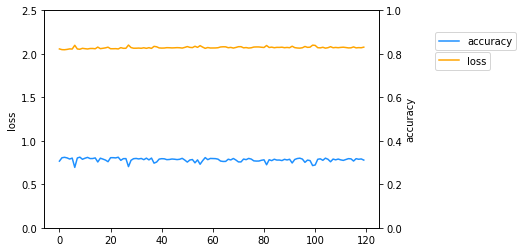

2 th Loop
Generating Training/Test Data


100%|████████████████████████████████████████████████████████████████████████| 146536/146536 [01:06<00:00, 2219.91it/s]


Training ...
stddev:  0.006944444444444444
stddev:  0.005524271728019903
stddev:  0.02946278254943948
epoch: 0  loss: 2.0494733  accuracy: 0.31746095
epoch: 1  loss: 2.046654  accuracy: 0.3220206
epoch: 2  loss: 2.0645845  accuracy: 0.30588236
epoch: 3  loss: 2.048575  accuracy: 0.32115653
epoch: 4  loss: 2.0543592  accuracy: 0.3187504
epoch: 5  loss: 2.0546868  accuracy: 0.31766036
epoch: 6  loss: 2.05007  accuracy: 0.3232303
epoch: 7  loss: 2.0529823  accuracy: 0.32026586
epoch: 8  loss: 2.05213  accuracy: 0.32115653
epoch: 9  loss: 2.0520418  accuracy: 0.3230708
epoch: 10  loss: 2.051495  accuracy: 0.32350948
epoch: 11  loss: 2.0520713  accuracy: 0.32353607
epoch: 12  loss: 2.05033  accuracy: 0.3254902
epoch: 13  loss: 2.0580952  accuracy: 0.31791294
epoch: 14  loss: 2.059153  accuracy: 0.31714192
epoch: 15  loss: 2.0591562  accuracy: 0.31785977
epoch: 16  loss: 2.054103  accuracy: 0.32253906
epoch: 17  loss: 2.0583763  accuracy: 0.31665006
epoch: 18  loss: 2.062273  accuracy: 0.314

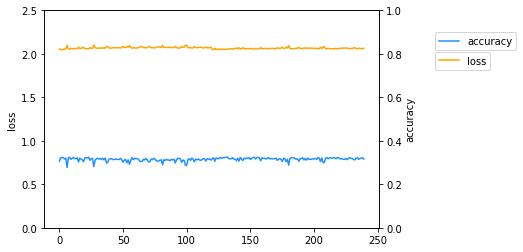

3 th Loop
Generating Training/Test Data


100%|████████████████████████████████████████████████████████████████████████| 146536/146536 [01:05<00:00, 2242.50it/s]


Training ...
stddev:  0.006944444444444444
stddev:  0.005524271728019903
stddev:  0.02946278254943948
epoch: 0  loss: 2.0558343  accuracy: 0.30976403
epoch: 1  loss: 2.0456603  accuracy: 0.32269856
epoch: 2  loss: 2.0473433  accuracy: 0.32369557
epoch: 3  loss: 2.0525818  accuracy: 0.31996012
epoch: 4  loss: 2.0492086  accuracy: 0.32373545
epoch: 5  loss: 2.0582373  accuracy: 0.3150947
epoch: 6  loss: 2.0544176  accuracy: 0.32038552
epoch: 7  loss: 2.0641584  accuracy: 0.31135926
epoch: 8  loss: 2.0596871  accuracy: 0.31565303
epoch: 9  loss: 2.0527728  accuracy: 0.322446
epoch: 10  loss: 2.056336  accuracy: 0.32026586
epoch: 11  loss: 2.0553904  accuracy: 0.32175472
epoch: 12  loss: 2.0626733  accuracy: 0.31465602
epoch: 13  loss: 2.0587337  accuracy: 0.31868395
epoch: 14  loss: 2.0554478  accuracy: 0.32147557
epoch: 15  loss: 2.056642  accuracy: 0.3216484
epoch: 16  loss: 2.0571156  accuracy: 0.32136923
epoch: 17  loss: 2.0687654  accuracy: 0.31032237
epoch: 18  loss: 2.0624871  accu

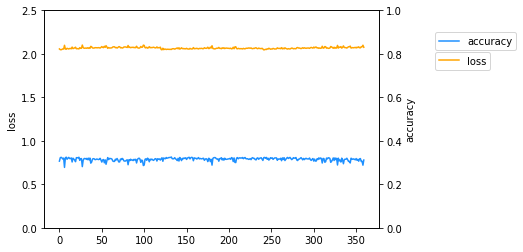

4 th Loop
Generating Training/Test Data


100%|████████████████████████████████████████████████████████████████████████| 146536/146536 [01:05<00:00, 2254.37it/s]


Training ...
stddev:  0.006944444444444444
stddev:  0.005524271728019903
stddev:  0.02946278254943948
epoch: 0  loss: 2.0481343  accuracy: 0.31825855
epoch: 1  loss: 2.0524833  accuracy: 0.3155467
epoch: 2  loss: 2.046779  accuracy: 0.32358924
epoch: 3  loss: 2.055784  accuracy: 0.31541377
epoch: 4  loss: 2.0547528  accuracy: 0.31805915
epoch: 5  loss: 2.049349  accuracy: 0.32475907
epoch: 6  loss: 2.0525439  accuracy: 0.32174143
epoch: 7  loss: 2.0518053  accuracy: 0.3232835
epoch: 8  loss: 2.0527363  accuracy: 0.32409438
epoch: 9  loss: 2.0585108  accuracy: 0.3189631
epoch: 10  loss: 2.0513952  accuracy: 0.325663
epoch: 11  loss: 2.058133  accuracy: 0.31887007
epoch: 12  loss: 2.0571945  accuracy: 0.3203988
epoch: 13  loss: 2.0532231  accuracy: 0.3232569
epoch: 14  loss: 2.0537305  accuracy: 0.32336324
epoch: 15  loss: 2.0542219  accuracy: 0.32174143
epoch: 16  loss: 2.0565548  accuracy: 0.32136923
epoch: 17  loss: 2.058394  accuracy: 0.32011965
epoch: 18  loss: 2.0518744  accuracy: 

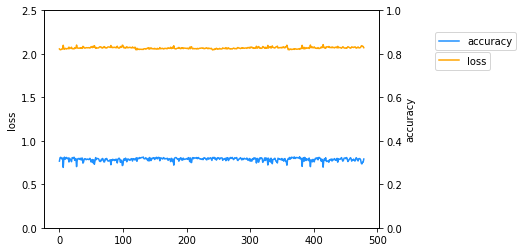

5 th Loop
Generating Training/Test Data


100%|████████████████████████████████████████████████████████████████████████| 146536/146536 [01:05<00:00, 2250.91it/s]


Training ...
stddev:  0.006944444444444444
stddev:  0.005524271728019903
stddev:  0.02946278254943948
epoch: 0  loss: 2.053798  accuracy: 0.31403124
epoch: 1  loss: 2.0503426  accuracy: 0.318551
epoch: 2  loss: 2.0498664  accuracy: 0.32138252
epoch: 3  loss: 2.059446  accuracy: 0.3131007
epoch: 4  loss: 2.0524683  accuracy: 0.3203988
epoch: 5  loss: 2.0614033  accuracy: 0.3123164
epoch: 6  loss: 2.0547469  accuracy: 0.31948155
epoch: 7  loss: 2.0620754  accuracy: 0.31359255
epoch: 8  loss: 2.05839  accuracy: 0.31702226
epoch: 9  loss: 2.0642126  accuracy: 0.31283483
epoch: 10  loss: 2.0540464  accuracy: 0.3226188
epoch: 11  loss: 2.0591147  accuracy: 0.31792623
epoch: 12  loss: 2.0602276  accuracy: 0.31582585
epoch: 13  loss: 2.061798  accuracy: 0.3159322
epoch: 14  loss: 2.066799  accuracy: 0.31135926
epoch: 15  loss: 2.066962  accuracy: 0.31139913
epoch: 16  loss: 2.0635803  accuracy: 0.31363243
epoch: 17  loss: 2.076923  accuracy: 0.30136257
epoch: 18  loss: 2.0610142  accuracy: 0.3

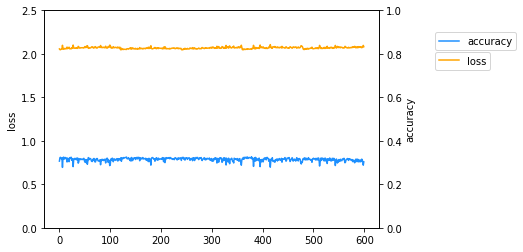

6 th Loop
Generating Training/Test Data


100%|████████████████████████████████████████████████████████████████████████| 146536/146536 [01:05<00:00, 2253.02it/s]


Training ...
stddev:  0.006944444444444444
stddev:  0.005524271728019903
stddev:  0.02946278254943948
epoch: 0  loss: 2.0643177  accuracy: 0.30178797
epoch: 1  loss: 2.0499682  accuracy: 0.3184048
epoch: 2  loss: 2.0507195  accuracy: 0.32038552
epoch: 3  loss: 2.0498047  accuracy: 0.32131606
epoch: 4  loss: 2.057149  accuracy: 0.3159721
epoch: 5  loss: 2.048816  accuracy: 0.32398805
epoch: 6  loss: 2.050963  accuracy: 0.3228581
epoch: 7  loss: 2.055871  accuracy: 0.31894982
epoch: 8  loss: 2.0585177  accuracy: 0.31763378
epoch: 9  loss: 2.071227  accuracy: 0.3054038
epoch: 10  loss: 2.0592682  accuracy: 0.31812564
epoch: 11  loss: 2.0539804  accuracy: 0.3230575
epoch: 12  loss: 2.0552814  accuracy: 0.3226321
epoch: 13  loss: 2.0647514  accuracy: 0.31238285
epoch: 14  loss: 2.060974  accuracy: 0.31540045
epoch: 15  loss: 2.0649703  accuracy: 0.3125291
epoch: 16  loss: 2.0579593  accuracy: 0.32066467
epoch: 17  loss: 2.0583148  accuracy: 0.32026586
epoch: 18  loss: 2.058456  accuracy: 0.

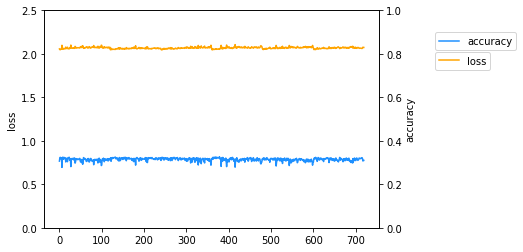

7 th Loop
Generating Training/Test Data


100%|████████████████████████████████████████████████████████████████████████| 146536/146536 [01:05<00:00, 2222.77it/s]


Training ...
stddev:  0.006944444444444444
stddev:  0.005524271728019903
stddev:  0.02946278254943948
epoch: 0  loss: 2.0545957  accuracy: 0.31098703
epoch: 1  loss: 2.0453722  accuracy: 0.322991
epoch: 2  loss: 2.0490127  accuracy: 0.32194084
epoch: 3  loss: 2.0507157  accuracy: 0.3216085
epoch: 4  loss: 2.0606127  accuracy: 0.31337985
epoch: 5  loss: 2.0575957  accuracy: 0.3173945
epoch: 6  loss: 2.056873  accuracy: 0.31881687
epoch: 7  loss: 2.0575018  accuracy: 0.3177534
epoch: 8  loss: 2.0569706  accuracy: 0.31988037
epoch: 9  loss: 2.057967  accuracy: 0.31883016
epoch: 10  loss: 2.0621655  accuracy: 0.3151213
epoch: 11  loss: 2.0570648  accuracy: 0.32112995
epoch: 12  loss: 2.0651693  accuracy: 0.3137255
epoch: 13  loss: 2.0631216  accuracy: 0.31570622
epoch: 14  loss: 2.0580773  accuracy: 0.32051843
epoch: 15  loss: 2.0628169  accuracy: 0.31670323
epoch: 16  loss: 2.0626588  accuracy: 0.31736788
epoch: 17  loss: 2.061888  accuracy: 0.3182054
epoch: 18  loss: 2.0608895  accuracy:

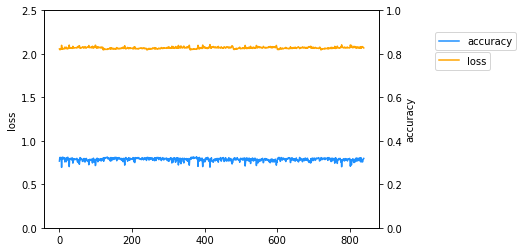

8 th Loop
Generating Training/Test Data


100%|████████████████████████████████████████████████████████████████████████| 146536/146536 [01:05<00:00, 2248.88it/s]


Training ...
stddev:  0.006944444444444444
stddev:  0.005524271728019903
stddev:  0.02946278254943948
epoch: 0  loss: 2.0526288  accuracy: 0.31445664
epoch: 1  loss: 2.053331  accuracy: 0.3151745
epoch: 2  loss: 2.0602772  accuracy: 0.30888668
epoch: 3  loss: 2.0489502  accuracy: 0.32158193
epoch: 4  loss: 2.0490134  accuracy: 0.32247257
epoch: 5  loss: 2.055509  accuracy: 0.3171685
epoch: 6  loss: 2.0569487  accuracy: 0.3167298
epoch: 7  loss: 2.0544815  accuracy: 0.31988037
epoch: 8  loss: 2.0500998  accuracy: 0.32414755
epoch: 9  loss: 2.05291  accuracy: 0.32237953
epoch: 10  loss: 2.050919  accuracy: 0.32410768
epoch: 11  loss: 2.051687  accuracy: 0.32470587
epoch: 12  loss: 2.0544136  accuracy: 0.32215354
epoch: 13  loss: 2.0534544  accuracy: 0.3230442
epoch: 14  loss: 2.0539145  accuracy: 0.3232968
epoch: 15  loss: 2.060368  accuracy: 0.31766036
epoch: 16  loss: 2.0559847  accuracy: 0.3214091
epoch: 17  loss: 2.0578687  accuracy: 0.3203988
epoch: 18  loss: 2.053726  accuracy: 0.3

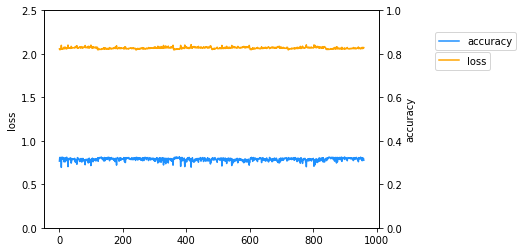

9 th Loop
Generating Training/Test Data


100%|████████████████████████████████████████████████████████████████████████| 146536/146536 [01:05<00:00, 2254.05it/s]


Training ...
stddev:  0.006944444444444444
stddev:  0.005524271728019903
stddev:  0.02946278254943948
epoch: 0  loss: 2.059602  accuracy: 0.30468595
epoch: 1  loss: 2.0565958  accuracy: 0.31017613
epoch: 2  loss: 2.0630026  accuracy: 0.3049651
epoch: 3  loss: 2.0472877  accuracy: 0.3218478
epoch: 4  loss: 2.0494244  accuracy: 0.32091725
epoch: 5  loss: 2.0536265  accuracy: 0.31764707
epoch: 6  loss: 2.0501926  accuracy: 0.32214025
epoch: 7  loss: 2.0508215  accuracy: 0.32058492
epoch: 8  loss: 2.0515032  accuracy: 0.320771
epoch: 9  loss: 2.0511825  accuracy: 0.31969425
epoch: 10  loss: 2.0513988  accuracy: 0.32179463
epoch: 11  loss: 2.0528975  accuracy: 0.32034564
epoch: 12  loss: 2.0568721  accuracy: 0.31668994
epoch: 13  loss: 2.0555284  accuracy: 0.31849784
epoch: 14  loss: 2.051669  accuracy: 0.3226188
epoch: 15  loss: 2.0712142  accuracy: 0.3029711
epoch: 16  loss: 2.0576007  accuracy: 0.31629112
epoch: 17  loss: 2.0562105  accuracy: 0.31668994
epoch: 18  loss: 2.0561543  accura

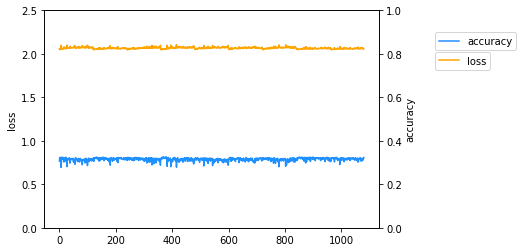

10 th Loop
Generating Training/Test Data


100%|████████████████████████████████████████████████████████████████████████| 146536/146536 [01:04<00:00, 2255.61it/s]


Training ...
stddev:  0.006944444444444444
stddev:  0.005524271728019903
stddev:  0.02946278254943948
epoch: 0  loss: 2.046949  accuracy: 0.3198006
epoch: 1  loss: 2.045062  accuracy: 0.32483882
epoch: 2  loss: 2.0513785  accuracy: 0.3203988
epoch: 3  loss: 2.056046  accuracy: 0.31768695
epoch: 4  loss: 2.0582223  accuracy: 0.31590563
epoch: 5  loss: 2.05488  accuracy: 0.319774
epoch: 6  loss: 2.0606067  accuracy: 0.3155201
epoch: 7  loss: 2.057728  accuracy: 0.31894982
epoch: 8  loss: 2.0604281  accuracy: 0.3167564
epoch: 9  loss: 2.056348  accuracy: 0.32134265
epoch: 10  loss: 2.0588124  accuracy: 0.31807244
epoch: 11  loss: 2.0700262  accuracy: 0.30854103
epoch: 12  loss: 2.0642066  accuracy: 0.3149618
epoch: 13  loss: 2.0705822  accuracy: 0.30854103
epoch: 14  loss: 2.0594916  accuracy: 0.32015952
epoch: 15  loss: 2.059446  accuracy: 0.32050514
epoch: 16  loss: 2.0592597  accuracy: 0.32091725
epoch: 17  loss: 2.0654523  accuracy: 0.31524095
epoch: 18  loss: 2.066194  accuracy: 0.31

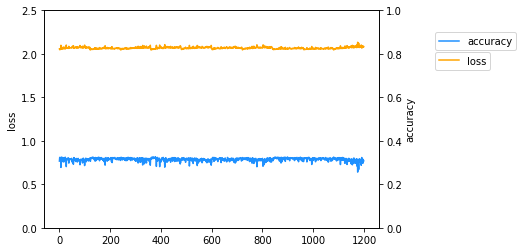

In [9]:
for loop in range(10):
    print(loop+1, "th Loop")
    print("Generating Training/Test Data")
    X_train, X_test, Y_train, Y_test = get_train_test_data(df_train)
    
    if loop == 0:
        model = DNN(n_in = len(X_train[1]), n_hiddens=[256, 256], n_out=9)

    print("Training ...")
    history = model.fit(X_train, Y_train, nb_epoch = 120, batch_size=32, p_keep=0.5)

    accuracy = model.evaluate(X_test, Y_test)
    print('accuracy: ', accuracy)
    plot(history)
